In [132]:
import random

import seaborn as sns
import numpy as np
import pandas as pd
import librosa

In [133]:
SAMPLE_RATE = 48000
FREQ_WINDOW = 48000
AMP_WINDOW = 480
LEFT_MOTOR_FREQ = 50
RIGHT_MOTOR_FREQ = 100

/opt/homebrew/lib/python3.9/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


(2, 330397)


<AxesSubplot:>

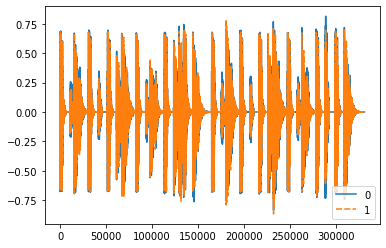

In [134]:
wav, sr = librosa.load("resources/test_sample.mp3", mono=False, sr=SAMPLE_RATE)
print(wav.shape)
sns.lineplot(data=np.transpose(wav), palette="tab10")

<AxesSubplot:>

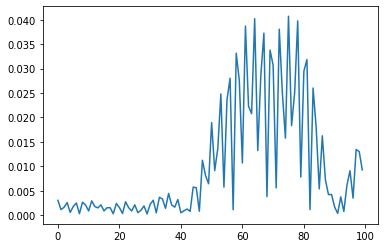

In [135]:
def power_distribution(wav, max_freq):
  raw = np.fft.fft(wav)
  res = np.abs(raw[0:max_freq])
  return res / np.sum(res)

dist = power_distribution(wav[1][0:FREQ_WINDOW], RIGHT_MOTOR_FREQ)
sns.lineplot(data=dist)

In [136]:
def pick_frequency(distribution, max_freq):
  target_power = random.random()
  current_sum = 0.0
  for i in range(max_freq):
    current_sum += distribution[i]
    if current_sum >= target_power:
      return i
  return max_freq

pick_frequency(dist, RIGHT_MOTOR_FREQ)

66

In [137]:
def get_true_amplitude(wav):
  return np.sum(np.abs(wav)) / wav.size

get_true_amplitude(wav[1][0:AMP_WINDOW])

0.30535538991292316

In [138]:
def delta_sigma_modulator(freq, max_freq, true_amp, prev_err, noise=0.0005, freq_priority=0.4):
  amp = abs(freq / max_freq + random.random() * noise)
  err = amp - true_amp + prev_err
  if err < freq_priority:
    return amp, err
  else:
    err = true_amp + prev_err
    return max(0, min(err, 1)), err - min(err, 1)

<AxesSubplot:>

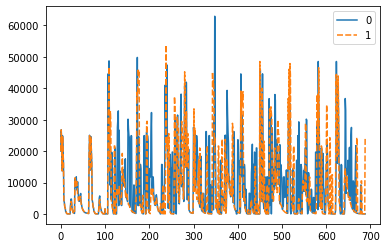

In [139]:
def process_wav(wav, max_freq):
  result = []
  err = 0
  for i in range(0, wav.size, AMP_WINDOW):
    true_amp = get_true_amplitude(wav[i:i+AMP_WINDOW])
    output = 0
    if i < FREQ_WINDOW:
      output, err = delta_sigma_modulator(true_amp * max_freq, max_freq, true_amp, err)
    else:
      dist = power_distribution(wav[i-FREQ_WINDOW:i], max_freq)
      freq = pick_frequency(dist, max_freq)
      output, err = delta_sigma_modulator(freq, max_freq, true_amp, err)
    result.append(output)
  return np.array(result)

left = process_wav(wav[0], LEFT_MOTOR_FREQ) * 65535
right = process_wav(wav[1], RIGHT_MOTOR_FREQ) * 65535
sns.lineplot(data=[left, right])